### Load and Prepare Data ###

In [60]:
import pandas as pd

In [61]:
#df = pd.read_csv("../data/kickstarter_cleaned.csv")
#df = pd.read_csv("../data/kickstarter_one_hot_cleaned.csv")
#df = pd.read_csv("../data/kickstarter_final_data.csv")

df = pd.read_csv("../../data/final.csv")

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#eliminate all non-numerical columns
df = df.select_dtypes(include=['number'])

#y is the target feature
y = df['SuccessfulBool']
#X consists of all features other than the target feature
X = df.drop('SuccessfulBool', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

### Utility Functions ###

#### Plot Cross Validation Scores ####

In [63]:
def plot_cv_scores(cv_scores):
    plt.boxplot(cv_scores, vert=True)  # vert=True is default, but can be specified explicitly
    plt.title("Cross-Validation Accuracy Scores")
    plt.ylabel("Accuracy")
    plt.xticks([1], ["Best Grid Model"])
    plt.grid(True)
    plt.show()
    '''
    plt.figure(figsize=(8, 5))
    plt.boxplot(cv_scores, vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
    plt.title("10-Fold Cross-Validation Scores")
    plt.xlabel("Accuracy")
    plt.yticks([1], ["Model"])
    plt.grid(True, axis='x')
    plt.show()
    '''

#### Plot Feature Importance Descending Importance ####

Given a model, makes a plot of the features by order of weightage in descending order. Note that decision trees are self ranking. Each split in the tree optimizes for the greatest reduction in error. The same feature can be split multiple times. The importance score of the feature is the total amount of impurity eliminated by splits of that specific feature.

In [64]:
def plot_feature_importances(model):
    # Assuming best_model is your trained model and X is your feature set
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)

    # Sort feature importances
    sorted_importances = feature_importances.sort_values(ascending=True)

    # Create horizontal bar plot
    plt.figure(figsize=(5, len(sorted_importances) * 0.3))  # Adjust height based on number of features
    sorted_importances.plot(kind='barh', color='skyblue')
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

#### Filter the Feature Importance List ####

Prints the feature list where the importance of the feature is above a minimum threshold value. The threshold has a range of 0.00 - 1.0.

In [65]:
def filter_feature_importance(model, threshold=0.01):

    importances = model.feature_importances_
    feature_names = X.columns

    importance_series = pd.Series(importances, index=feature_names)

    # Filter features with importance > 0.01
    important_features = importance_series[importance_series > threshold]

    # Print the column names
    print(important_features.index.tolist())

#### Graph the first 2 levels of the tree ####

In [66]:
from sklearn.tree import plot_tree

def graph_tree_struct(model):
    plt.figure(figsize=(20, 10))  # Adjust size as needed
    plot_tree(
        model,                        # your trained decision tree classifier
        feature_names=X.columns,   # feature names
        class_names=['Fail', 'Success'],  # adjust if your classes differ
        filled=True, 
        rounded=True, 
        fontsize=10,
        max_depth=2
    )
    plt.show()

### Decision Tree ###

In [67]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer, f1_score
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#thresholds = np.arange()

def grid_search_roc_auc_tree(X, y, param_grid, cv=10, random_state=42, return_feature_importance=False, return_cv_scores=False):
    clf = DecisionTreeClassifier(random_state=42)
    grid = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)

    # Now get the best model
    best_model = grid.best_estimator_

    # Predict probabilities
    y_probs = best_model.predict_proba(X_test)[:, 1]  # Use a validation set here

    '''
    y_scores = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    '''
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Try different thresholds manually
    thresholds = np.arange(0.1, 0.7, 0.1)
    best_threshold_score = {'thresh': None, 'f1': None, 'classification_report': None, 'confusion_matrix': None}
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(y_test, y_pred)
        classification_report_output = classification_report(y_test, y_pred)

        #print(classification_report(y_test, y_pred))
        print(f"Threshold: {t:.2f} -> F1 Score: {score:.4f}")
        if(best_threshold_score['thresh'] == None):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)
        elif(score > best_threshold_score['f1']):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)

    return {
        'cv_accuracy': grid.best_score_,
        'best_params': grid.best_params_,
        'best_thresh': best_threshold_score,
        'best_model': best_model,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'grid': grid,
        'best_index': grid.best_index_
    }

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Threshold: 0.10 -> F1 Score: 0.5820
Threshold: 0.20 -> F1 Score: 0.6061
Threshold: 0.30 -> F1 Score: 0.6209
Threshold: 0.40 -> F1 Score: 0.6112
Threshold: 0.50 -> F1 Score: 0.5300
Threshold: 0.60 -> F1 Score: 0.4639
mean cv_score: 0.706545561955398 cv_std_score: 0.016193999062813297


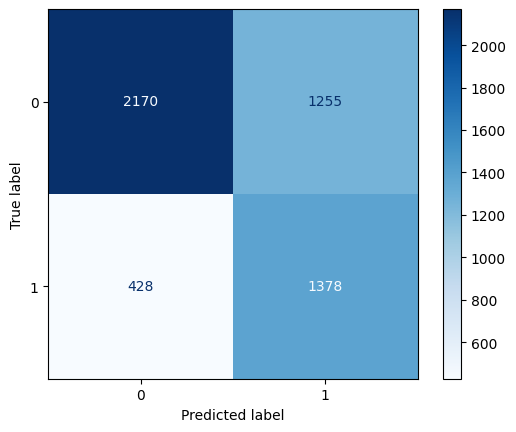

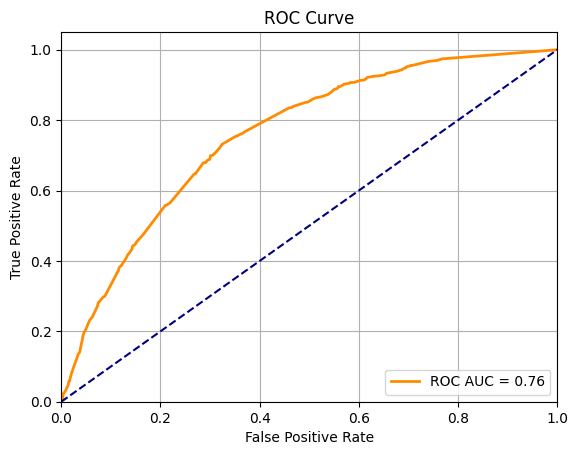

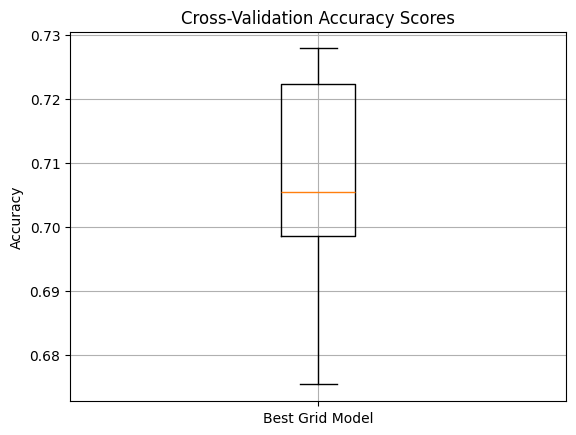

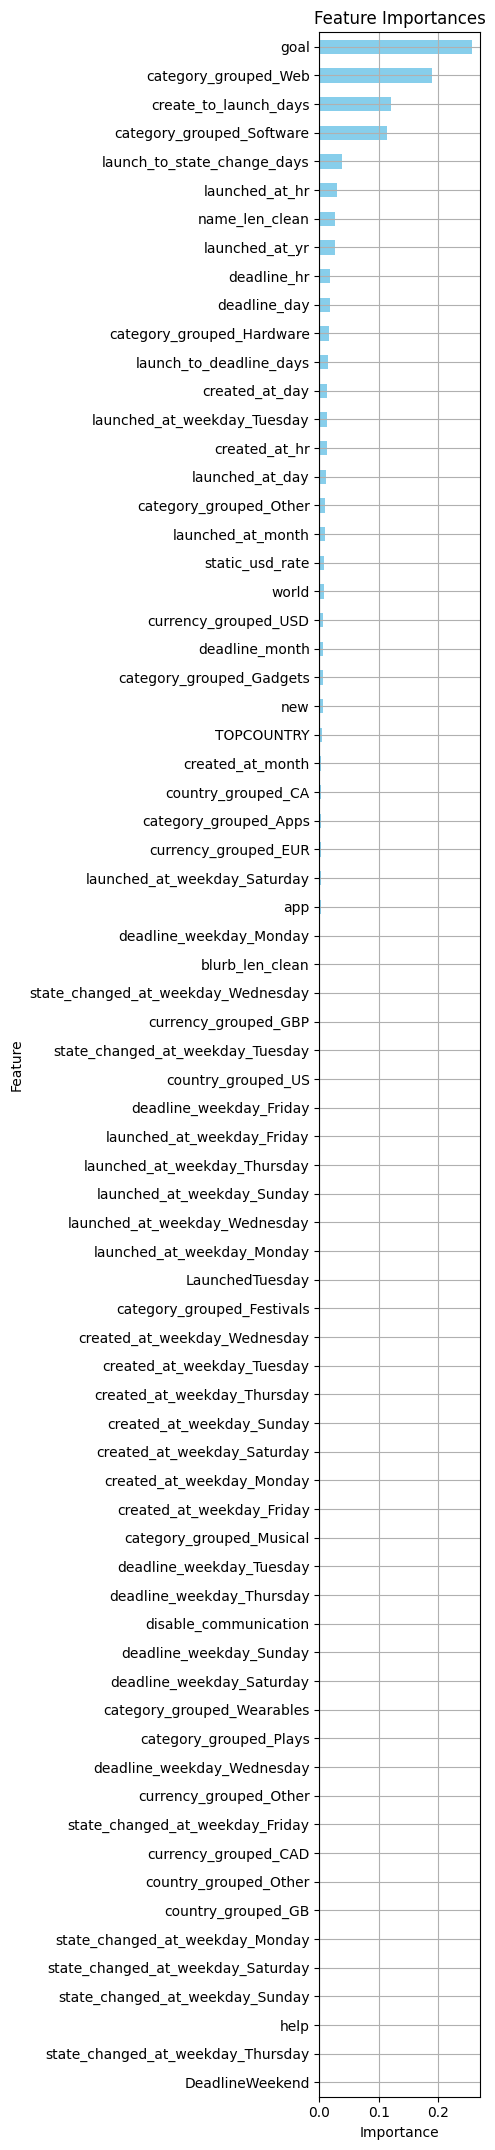

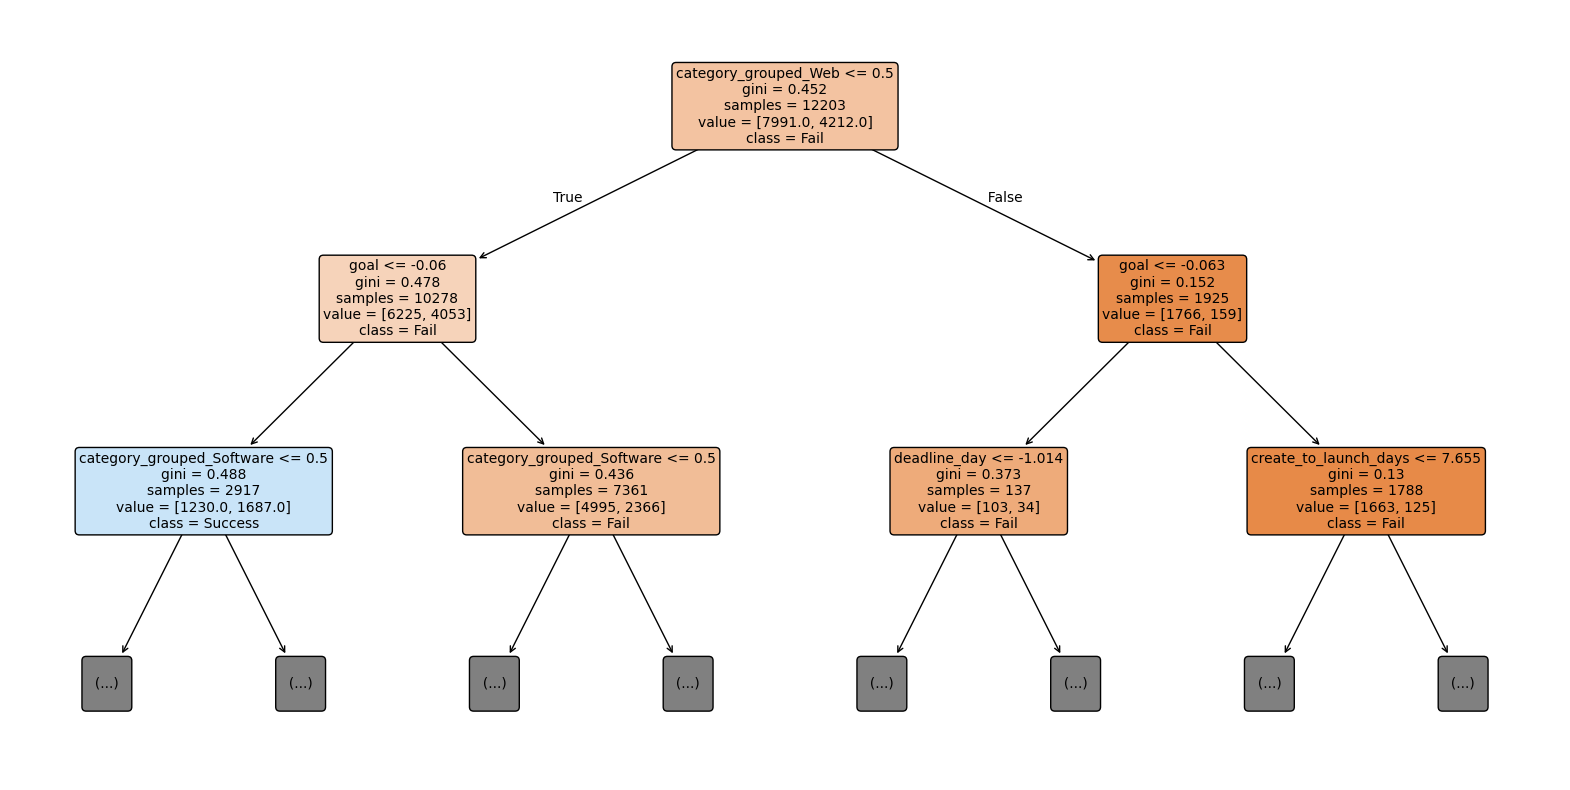

['goal', 'name_len_clean', 'deadline_day', 'deadline_hr', 'created_at_day', 'created_at_hr', 'launched_at_day', 'launched_at_yr', 'launched_at_hr', 'create_to_launch_days', 'launch_to_deadline_days', 'launch_to_state_change_days', 'launched_at_weekday_Tuesday', 'category_grouped_Hardware', 'category_grouped_Software', 'category_grouped_Web']


In [68]:

decision_tree_param_grid = {
    'max_depth': range(10, 12),
    'min_samples_leaf': range(12, 15),
    'min_samples_split': range(2, 10)
}

#def grid_search_roc_auc_tree(X, y, param_grid, cv=10, random_state=42, return_feature_importance=False, return_cv_scores=False):

result_decision_tree = grid_search_roc_auc_tree(X, y, param_grid=decision_tree_param_grid, return_feature_importance=False, return_cv_scores=False)

#print(result_decision_tree)


best_model_index = result_decision_tree['best_index']
print(f"mean cv_score: {result_decision_tree['grid'].cv_results_['mean_test_score'][best_model_index]} cv_std_score: {result_decision_tree['grid'].cv_results_['std_test_score'][best_model_index]}")


#confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=result_decision_tree['best_thresh']['confusion_matrix'], display_labels=[0, 1])
disp.plot(cmap='Blues')

#roc graph
plt.figure()
plt.plot(result_decision_tree['fpr'], result_decision_tree['tpr'], color='darkorange', lw=2, label=f'ROC AUC = {result_decision_tree['roc_auc']:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

grid = result_decision_tree['grid']
cv_scores = [grid.cv_results_[f'split{i}_test_score'][best_model_index] for i in range(grid.cv)]  # grid.cv is usually 10
plot_cv_scores(cv_scores)

plot_feature_importances(result_decision_tree['best_model'])
graph_tree_struct(result_decision_tree['best_model'])

filter_feature_importance(result_decision_tree['best_model'])

## Gradient Boost Decision Trees ##

Rerun the above tests but with Gradient Boost Classifier. Gradients of the loss function.

In [69]:
from sklearn.ensemble import GradientBoostingClassifier


def grid_search_roc_auc_gradient_boost_tree(X, y, param_grid, cv=10, random_state=42):
    #    grid = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10)
    clf = GradientBoostingClassifier(random_state=random_state)
    grid = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Now get the best model
    best_model = grid.best_estimator_

    # Predict probabilities
    y_probs = best_model.predict_proba(X_test)[:, 1]  # Use a validation set here

    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Try different thresholds manually
    thresholds = np.arange(0.1, 0.7, 0.1)
    best_threshold_score = {'thresh': None, 'f1': None, 'classification_report': None, 'confusion_matrix': None}
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(y_test, y_pred)
        classification_report_output = classification_report(y_test, y_pred)

        #print(classification_report(y_test, y_pred))
        print(f"Threshold: {t:.2f} -> F1 Score: {score:.4f}")
        if(best_threshold_score['thresh'] == None):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)
        elif(score > best_threshold_score['f1']):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)

    return {
        'cv_accuracy': grid.best_score_,
        'best_params': grid.best_params_,
        'best_thresh': best_threshold_score,
        'best_model': best_model,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'grid': grid,
        'best_index': grid.best_index_
    }

Threshold: 0.10 -> F1 Score: 0.5812
Threshold: 0.20 -> F1 Score: 0.6387
Threshold: 0.30 -> F1 Score: 0.6588
Threshold: 0.40 -> F1 Score: 0.6494
Threshold: 0.50 -> F1 Score: 0.5974
Threshold: 0.60 -> F1 Score: 0.4781
{'cv_accuracy': np.float64(0.743340583504518), 'best_params': {'learning_rate': np.float64(0.07999999999999999), 'loss': 'log_loss', 'max_depth': 4, 'n_estimators': 100}, 'best_thresh': {'thresh': np.float64(0.30000000000000004), 'f1': 0.6588235294117647, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.88      0.63      0.73      3425\n           1       0.54      0.84      0.66      1806\n\n    accuracy                           0.70      5231\n   macro avg       0.71      0.73      0.70      5231\nweighted avg       0.76      0.70      0.71      5231\n', 'confusion_matrix': array([[2153, 1272],
       [ 294, 1512]])}, 'best_model': GradientBoostingClassifier(learning_rate=np.float64(0.07999999999999999),
            

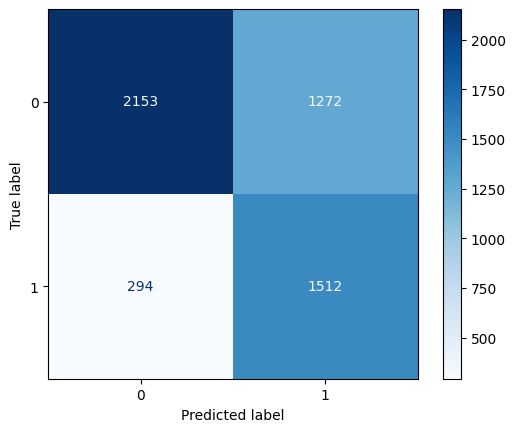

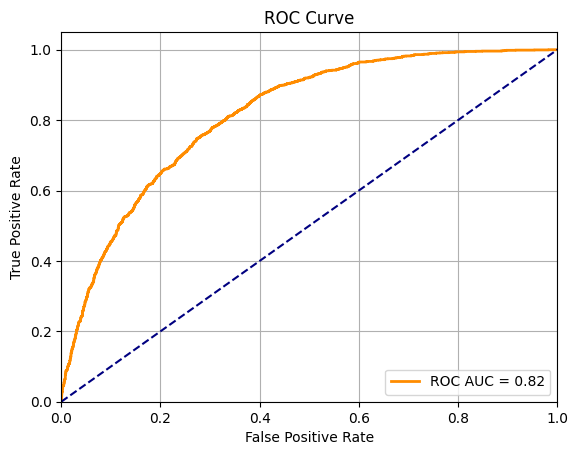

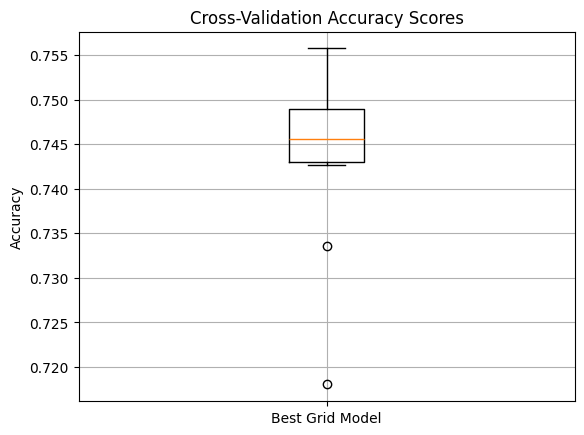

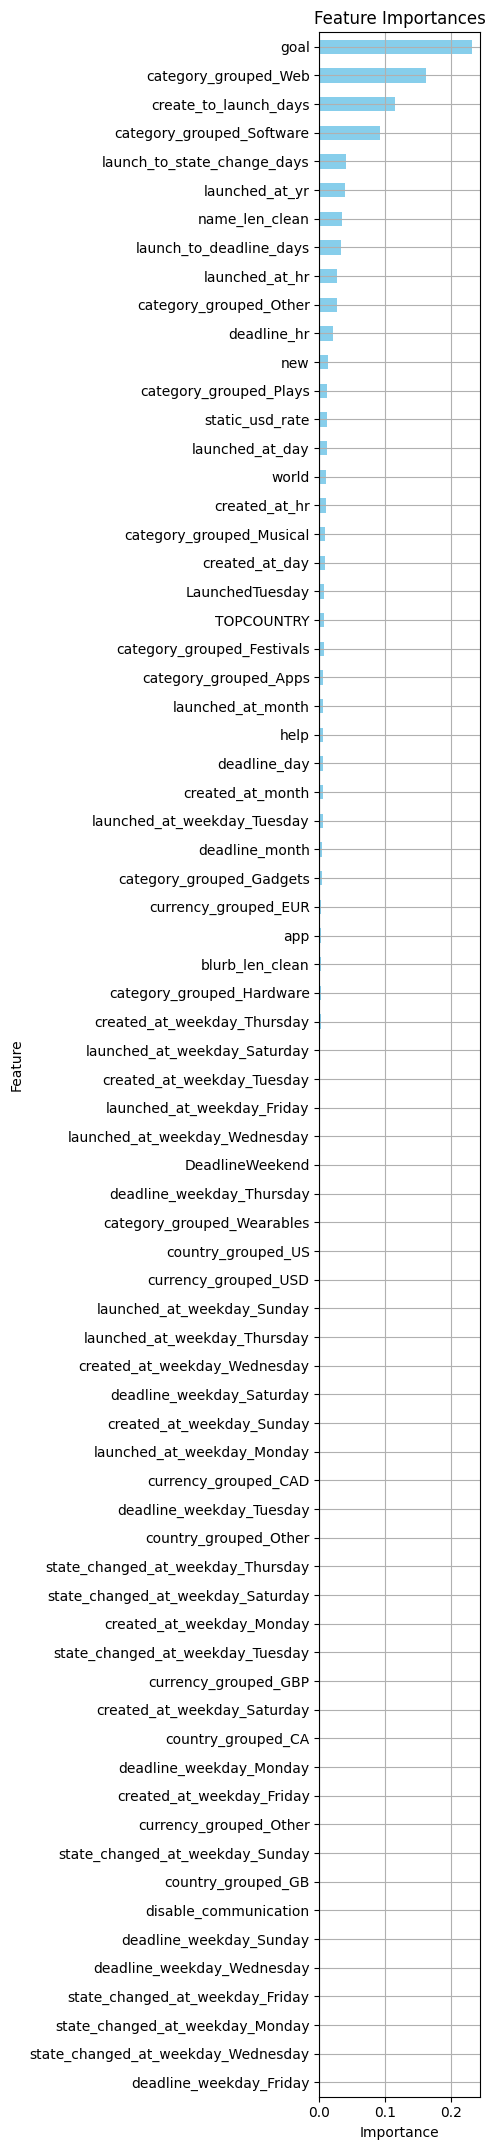

['goal', 'static_usd_rate', 'name_len_clean', 'deadline_hr', 'created_at_hr', 'launched_at_day', 'launched_at_yr', 'launched_at_hr', 'create_to_launch_days', 'launch_to_deadline_days', 'launch_to_state_change_days', 'new', 'world', 'category_grouped_Other', 'category_grouped_Plays', 'category_grouped_Software', 'category_grouped_Web']


In [70]:

gradient_boost_tree_param_grid = {
    'loss': ['log_loss'],#loss function. log_loss is the default
    'learning_rate': np.arange(0.06, 0.09, 0.01),
    'n_estimators': range(75, 125, 25),
    'max_depth': [4],#smaller since there are many estimators.
    #'min_samples_leaf': range(10, 30, 5),
    #'min_samples_split': range(10, 15),
}

#def grid_search_roc_auc_tree(X, y, param_grid, cv=10, random_state=42, return_feature_importance=False, return_cv_scores=False):

result_gradient_boost = grid_search_roc_auc_gradient_boost_tree(X, y, param_grid=gradient_boost_tree_param_grid)

print(result_gradient_boost)

best_model_index = result_gradient_boost['best_index']
print(f"mean cv_score: {result_gradient_boost['grid'].cv_results_['mean_test_score'][best_model_index]} cv_std_score: {result_gradient_boost['grid'].cv_results_['std_test_score'][best_model_index]}")



#confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=result_gradient_boost['best_thresh']['confusion_matrix'], display_labels=[0, 1])
disp.plot(cmap='Blues')

#roc graph
plt.figure()
plt.plot(result_gradient_boost['fpr'], result_gradient_boost['tpr'], color='darkorange', lw=2, label=f'ROC AUC = {result_gradient_boost['roc_auc']:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

grid = result_gradient_boost['grid']
cv_scores = [grid.cv_results_[f'split{i}_test_score'][best_model_index] for i in range(grid.cv)]  # grid.cv is usually 10
plot_cv_scores(cv_scores)

plot_feature_importances(result_gradient_boost['best_model'])

filter_feature_importance(result_gradient_boost['best_model'])


### Adaboost ###

In [71]:
from sklearn.ensemble import AdaBoostClassifier


def grid_search_roc_auc_adaboost_tree(X, y, param_grid, cv=10, random_state=42):

    #basic learner decision tree
    dt = DecisionTreeClassifier(random_state=random_state)

    ada_boost = AdaBoostClassifier(estimator=dt, random_state=random_state)

    grid = GridSearchCV(ada_boost, param_grid, cv=10, n_jobs=-1, verbose=1)

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_


    # Predict probabilities
    y_probs = best_model.predict_proba(X_test)[:, 1]  # Use a validation set here

    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Try different thresholds manually
    thresholds = np.arange(0.1, 0.7, 0.1)
    best_threshold_score = {'thresh': None, 'f1': None, 'classification_report': None, 'confusion_matrix': None}
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(y_test, y_pred)
        classification_report_output = classification_report(y_test, y_pred)

        #print(classification_report(y_test, y_pred))
        print(f"Threshold: {t:.2f} -> F1 Score: {score:.4f}")
        if(best_threshold_score['thresh'] == None):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)
        elif(score > best_threshold_score['f1']):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)

    return {
        'cv_accuracy': grid.best_score_,
        'best_params': grid.best_params_,
        'best_thresh': best_threshold_score,
        'best_model': best_model,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'grid': grid,
        'best_index': grid.best_index_
    }

Fitting 10 folds for each of 33 candidates, totalling 330 fits
Threshold: 0.10 -> F1 Score: 0.5133
Threshold: 0.20 -> F1 Score: 0.5786
Threshold: 0.30 -> F1 Score: 0.6072
Threshold: 0.40 -> F1 Score: 0.6487
Threshold: 0.50 -> F1 Score: 0.6068
Threshold: 0.60 -> F1 Score: 0.2607
{'cv_accuracy': np.float64(0.7397350330956889), 'best_params': {'estimator__max_depth': 9, 'learning_rate': np.float64(0.07), 'n_estimators': 400}, 'best_thresh': {'thresh': np.float64(0.4), 'f1': 0.6487050960735171, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.89      0.58      0.70      3425\n           1       0.52      0.86      0.65      1806\n\n    accuracy                           0.68      5231\n   macro avg       0.70      0.72      0.68      5231\nweighted avg       0.76      0.68      0.68      5231\n', 'confusion_matrix': array([[1996, 1429],
       [ 253, 1553]])}, 'best_model': AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=

/Users/williamgreen/Documents/GitHub/kickstarter-project-success-predictions/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/williamgreen/Documents/GitHub/kickstarter-project-success-predictions/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/williamgreen/Documents/GitHub/kickstarter-project-success-predictions/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

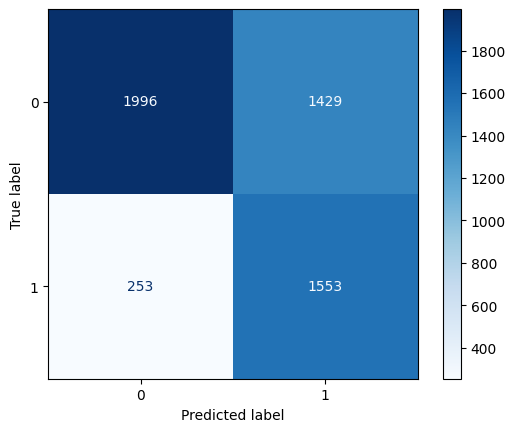

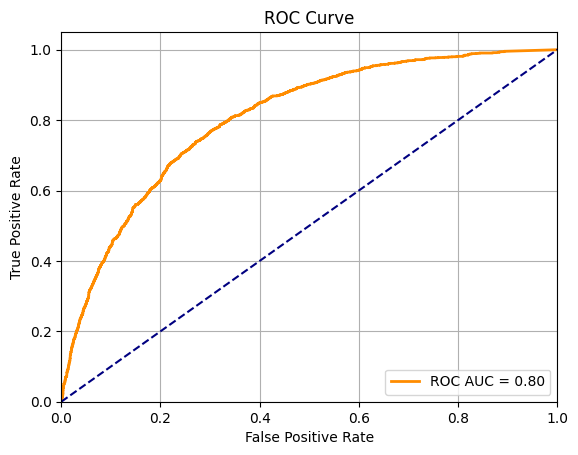

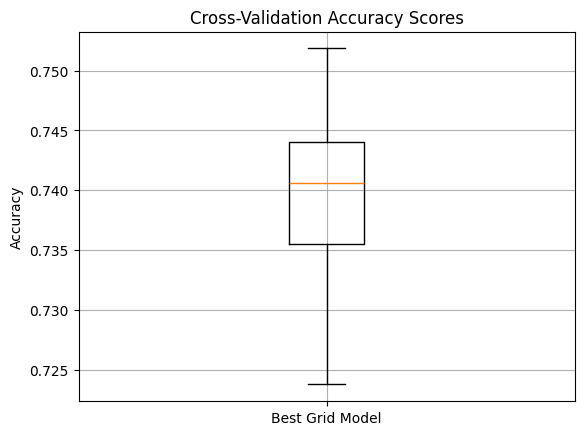

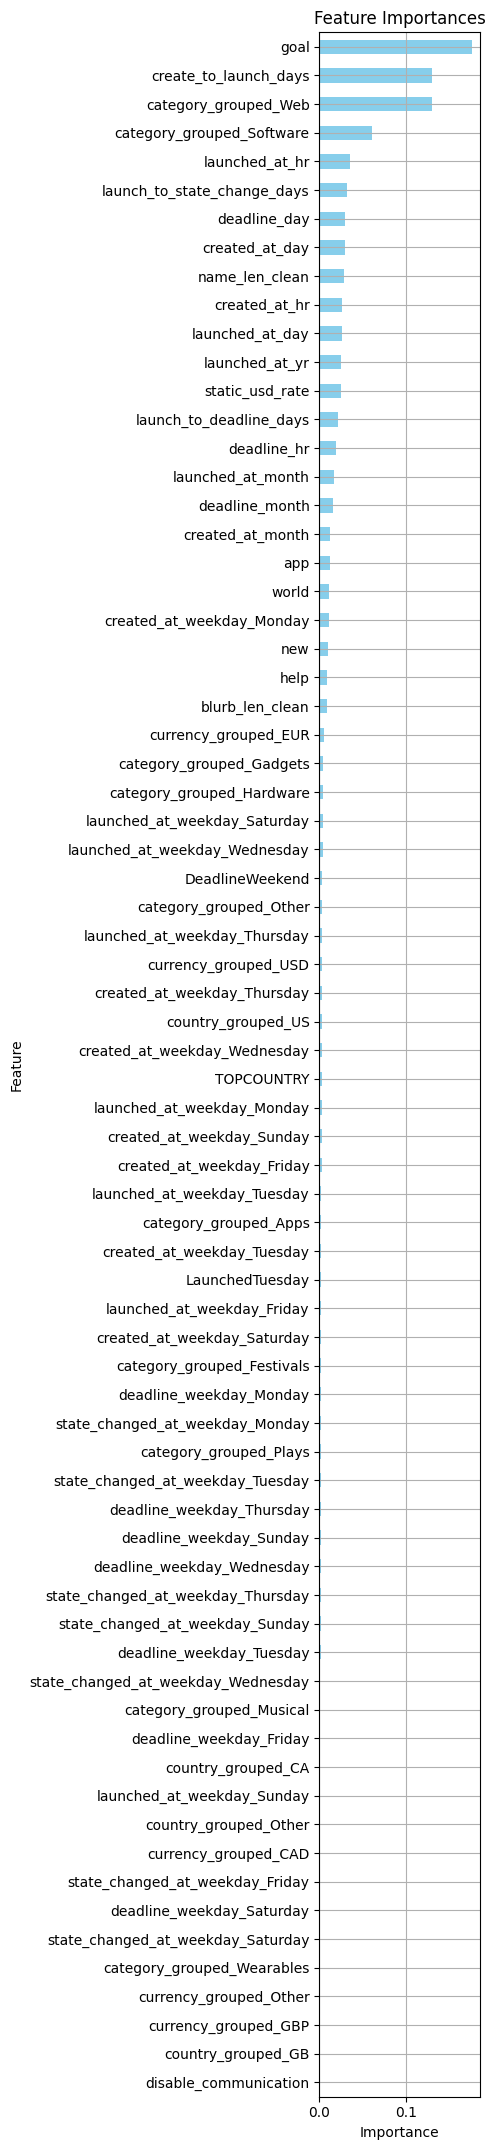

['goal', 'static_usd_rate', 'name_len_clean', 'deadline_month', 'deadline_day', 'deadline_hr', 'created_at_month', 'created_at_day', 'created_at_hr', 'launched_at_month', 'launched_at_day', 'launched_at_yr', 'launched_at_hr', 'create_to_launch_days', 'launch_to_deadline_days', 'launch_to_state_change_days', 'app', 'world', 'created_at_weekday_Monday', 'category_grouped_Software', 'category_grouped_Web']


In [72]:
ada_boost_param_grid = {
    'estimator__max_depth': [9],#range(7, 12),  # Tuning the depth of the DecisionTree
    'n_estimators': [400],  # Number of estimators in AdaBoost
    'learning_rate': np.arange(0.05, 0.7, 0.02),  # Learning rate of AdaBoost
    #'estimator__min_samples_leaf': range(6, 7, 1)
}

#def grid_search_roc_auc_tree(X, y, param_grid, cv=10, random_state=42, return_feature_importance=False, return_cv_scores=False):

result_ada_boost = grid_search_roc_auc_adaboost_tree(X, y, param_grid=ada_boost_param_grid)

print(result_ada_boost)

best_model_index = result_ada_boost['best_index']
print(f"mean cv_score: {result_ada_boost['grid'].cv_results_['mean_test_score'][best_model_index]} cv_std_score: {result_ada_boost['grid'].cv_results_['std_test_score'][best_model_index]}")




#confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=result_ada_boost['best_thresh']['confusion_matrix'], display_labels=[0, 1])
disp.plot(cmap='Blues')

#roc graph
plt.figure()
plt.plot(result_ada_boost['fpr'], result_ada_boost['tpr'], color='darkorange', lw=2, label=f'ROC AUC = {result_ada_boost['roc_auc']:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

grid = result_ada_boost['grid']
cv_scores = [grid.cv_results_[f'split{i}_test_score'][best_model_index] for i in range(grid.cv)]  # grid.cv is usually 10
plot_cv_scores(cv_scores)

plot_feature_importances(result_ada_boost['best_model'])

filter_feature_importance(result_ada_boost['best_model'])



## Random Forest ##

In [73]:
from sklearn.ensemble import RandomForestClassifier


def grid_search_roc_auc_random_forest_tree(X, y, param_grid, cv=10, random_state=42):
    #    grid = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10)
    clf = RandomForestClassifier(random_state=random_state)
    grid = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)

    # Now get the best model
    best_model = grid.best_estimator_

    # Predict probabilities
    y_probs = best_model.predict_proba(X_test)[:, 1]  # Use a validation set here

    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Try different thresholds manually
    thresholds = np.arange(0.1, 0.7, 0.1)
    best_threshold_score = {'thresh': None, 'f1': None, 'classification_report': None, 'confusion_matrix': None}
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(y_test, y_pred)
        classification_report_output = classification_report(y_test, y_pred)

        #print(classification_report(y_test, y_pred))
        print(f"Threshold: {t:.2f} -> F1 Score: {score:.4f}")
        if(best_threshold_score['thresh'] == None):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)
        elif(score > best_threshold_score['f1']):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
            best_threshold_score['classification_report'] = classification_report_output
            best_threshold_score['confusion_matrix'] = confusion_matrix(y_test, y_pred)

    return {
        'cv_accuracy': grid.best_score_,
        'best_params': grid.best_params_,
        'best_thresh': best_threshold_score,
        'best_model': best_model,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'grid': grid,
        'best_index': grid.best_index_
    }

Fitting 10 folds for each of 80 candidates, totalling 800 fits
Threshold: 0.10 -> F1 Score: 0.5535
Threshold: 0.20 -> F1 Score: 0.6115
Threshold: 0.30 -> F1 Score: 0.6474
Threshold: 0.40 -> F1 Score: 0.6442
Threshold: 0.50 -> F1 Score: 0.5636
Threshold: 0.60 -> F1 Score: 0.3892
{'cv_accuracy': np.float64(0.7367836763738403), 'best_params': {'criterion': 'gini', 'max_depth': 21, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 55}, 'best_thresh': {'thresh': np.float64(0.30000000000000004), 'f1': 0.6474183350895679, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.88      0.59      0.71      3425\n           1       0.52      0.85      0.65      1806\n\n    accuracy                           0.68      5231\n   macro avg       0.70      0.72      0.68      5231\nweighted avg       0.76      0.68      0.69      5231\n', 'confusion_matrix': array([[2022, 1403],
       [ 270, 1536]])}, 'best_model': RandomForestClassifier(m

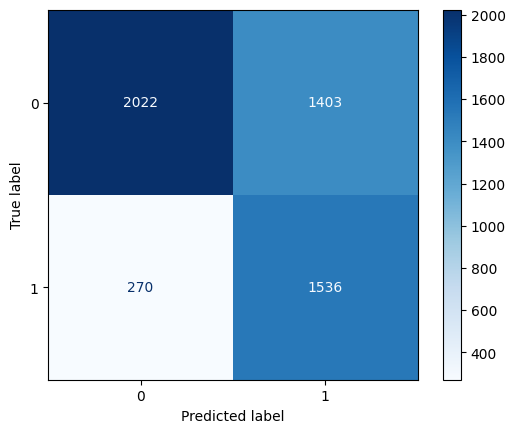

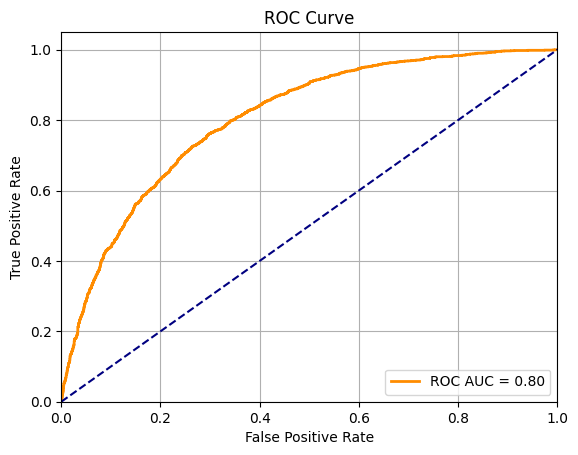

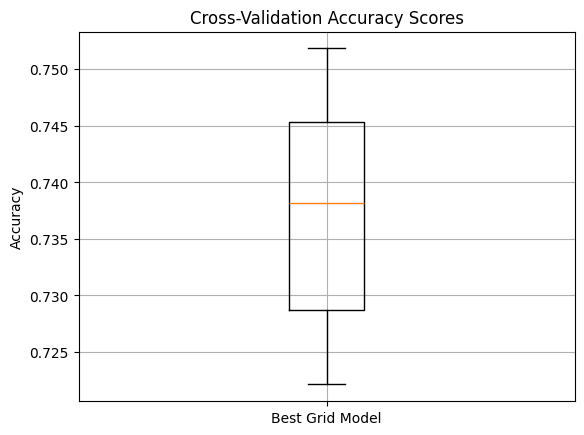

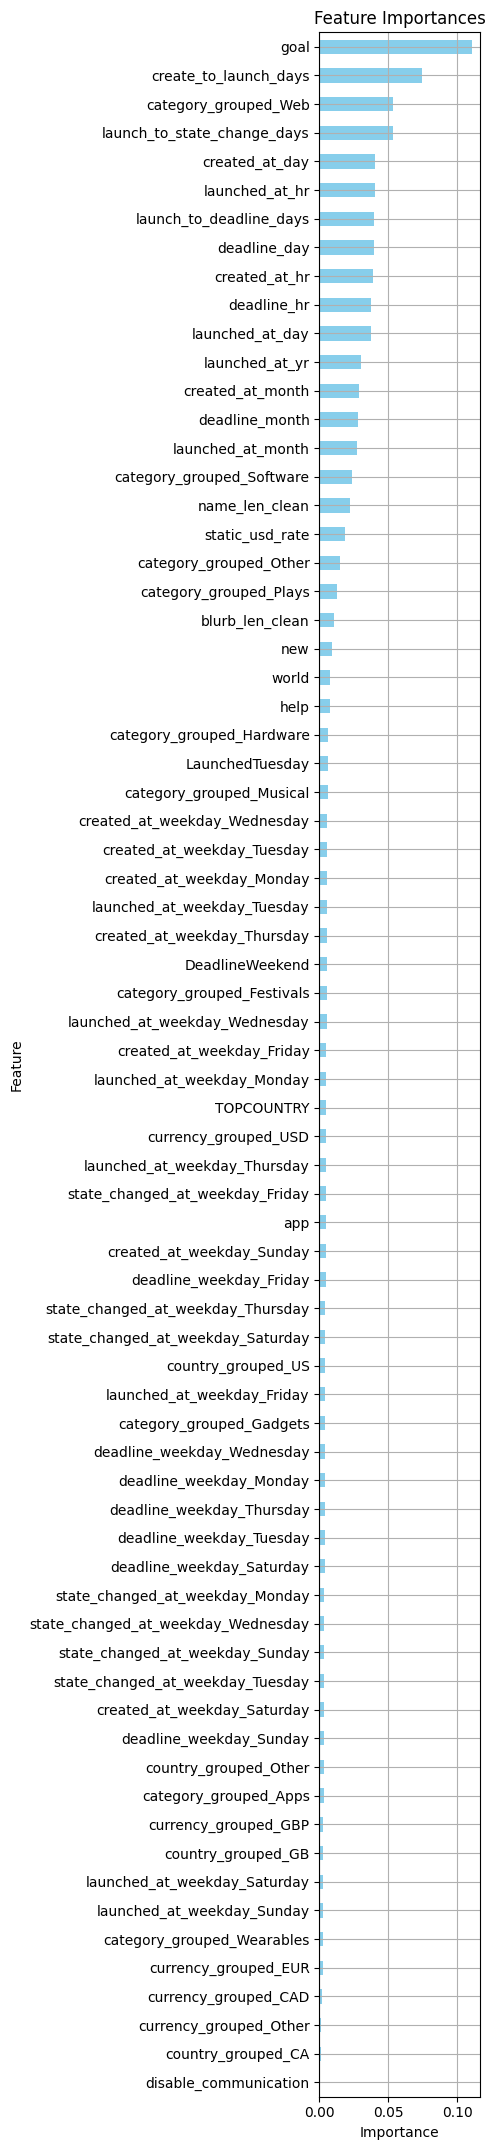

['goal', 'static_usd_rate', 'name_len_clean', 'blurb_len_clean', 'deadline_month', 'deadline_day', 'deadline_hr', 'created_at_month', 'created_at_day', 'created_at_hr', 'launched_at_month', 'launched_at_day', 'launched_at_yr', 'launched_at_hr', 'create_to_launch_days', 'launch_to_deadline_days', 'launch_to_state_change_days', 'category_grouped_Other', 'category_grouped_Plays', 'category_grouped_Software', 'category_grouped_Web']


In [75]:

random_forest_tree_param_grid = {
    'criterion': ['gini'],#split criterion. gini is default
    #'learning_rate': np.arange(0.01, 0.2, 0.02),
    'n_estimators': range(40, 60, 5),
    'min_samples_split': range(5, 10, 1),
    'max_depth': range(18, 23, 1),#smaller since there are many estimators.
    'min_samples_leaf': range(2, 7, 5),
    'min_samples_split': range(4, 8),
}

'''
ada_boost_param_grid = {
    'estimator__max_depth': range(4, 10),  # Tuning the depth of the DecisionTree
    'n_estimators': [200, 400, 600],  # Number of estimators in AdaBoost
    'learning_rate': np.arange(0.2, 1.0, 0.2),  # Learning rate of AdaBoost
}
'''

#def grid_search_roc_auc_tree(X, y, param_grid, cv=10, random_state=42, return_feature_importance=False, return_cv_scores=False):

result_random_forest = grid_search_roc_auc_random_forest_tree(X, y, param_grid=random_forest_tree_param_grid)

print(result_random_forest)
best_model_index = result_random_forest['best_index']
print(f"mean cv_score: {result_random_forest['grid'].cv_results_['mean_test_score'][best_model_index]} cv_std_score: {result_random_forest['grid'].cv_results_['std_test_score'][best_model_index]}")


#confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=result_random_forest['best_thresh']['confusion_matrix'], display_labels=[0, 1])
disp.plot(cmap='Blues')

#roc graph
plt.figure()
plt.plot(result_random_forest['fpr'], result_random_forest['tpr'], color='darkorange', lw=2, label=f'ROC AUC = {result_random_forest['roc_auc']:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

grid = result_random_forest['grid']
cv_scores = [grid.cv_results_[f'split{i}_test_score'][best_model_index] for i in range(grid.cv)]  # grid.cv is usually 10
plot_cv_scores(cv_scores)

plot_feature_importances(result_random_forest['best_model'])
#graph_tree_struct(result_random_forest['best_model'])

filter_feature_importance(result_random_forest['best_model'])
